**install requirements**

In [11]:
# !pip install importnb
# !pip install torch torchvision torchaudio

**Run main notebook directly and load result to dataframe**

In [13]:
# from importnb import Notebook
# import json
# import pandas as pd
# import matplotlib.pyplot as plt

# with Notebook():
#     import main  

# results = main2.results  
# df = pd.json_normalize(results)

# print(df.head())

**Load existing json file to dataframe**

In [15]:
import os
import json
import pandas as pd

# Define the path to the results.json file
results_file = os.path.abspath(os.path.join("..", "data", "processed", "results.json"))

# Load the results JSON file
if os.path.exists(results_file):
    with open(results_file, "r") as f:
        results = json.load(f)

    df = pd.json_normalize(results)

    print(df.head())
else:
    print(f"File not found: {results_file}")

                                               query expected  \
0  PROVISION OF LOGISTICS SERVICES FOR HOME TEAM ...   212401   
1  WOG Video and Animation Period Contract and Fr...   218999   
2  PROVISION OF CATERING SERVICES    [Catering 01...   212901   
3  PROVISION OF LOGISTICS SERVICES FOR HOME TEAM ...   212401   
4  PROVISION OF LOGISTICS SERVICES FOR HOME TEAM ...   212401   

                             expected_description  \
0  Other Equipment511999 - Direct Project: Others   
1           Other Services511699 - Other Services   
2     Other Assets511999 - Direct Project: Others   
3  Other Equipment511999 - Direct Project: Others   
4  Other Equipment511999 - Direct Project: Others   

                                     retrieved_top_5  \
0  [{'material_number': '213902', 'description': ...   
1  [{'material_number': '276101', 'description': ...   
2  [{'material_number': '213201', 'description': ...   
3  [{'material_number': '213101', 'description': ...   
4  [{'mate

**Calculate Overall Metrics**

In [17]:
# Calculate accuracy
accuracy = df["is_correct"].mean()
print(f"Overall Accuracy: {accuracy:.2%}")

# Average similarity scores
correct_scores = df[df["is_correct"]]["similarity_scores"].apply(lambda x: x[0]).mean()
incorrect_scores = df[~df["is_correct"]]["similarity_scores"].apply(lambda x: x[0]).mean()
print(f"Average Similarity Score (Correct): {correct_scores:.2f}%")
print(f"Average Similarity Score (Incorrect): {incorrect_scores:.2f}%")

Overall Accuracy: 24.88%
Average Similarity Score (Correct): 44.51%
Average Similarity Score (Incorrect): 38.45%


**Confidence vs. Accuracy**

Accuracy by Similarity Score Range:
score_bin
(0, 40]      0.153158
(40, 60]     0.363132
(60, 80]     0.911765
(80, 100]    0.000000
Name: is_correct, dtype: float64


C:\Users\Jason\AppData\Local\Temp\ipykernel_1636\1612922818.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_score = df.groupby("score_bin")["is_correct"].mean()


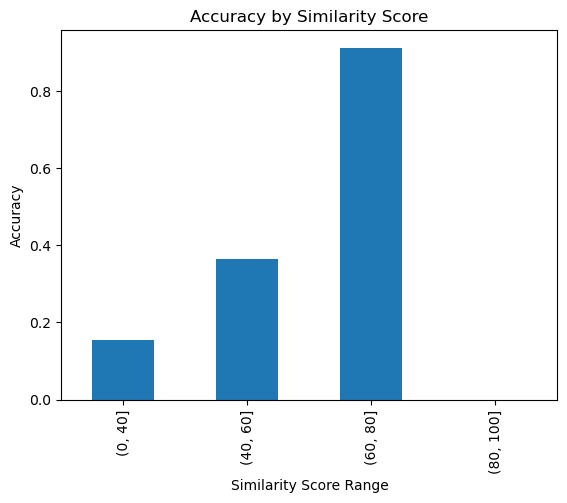

In [24]:
from matplotlib import pyplot as plt

# Bin similarity scores
bins = [0, 40, 60, 80, 100]
df["score_bin"] = pd.cut(df["similarity_scores"].apply(lambda x: x[0]), bins)
accuracy_by_score = df.groupby("score_bin")["is_correct"].mean()

print("Accuracy by Similarity Score Range:")
print(accuracy_by_score)

# Plot accuracy by similarity score
accuracy_by_score.plot(kind="bar", title="Accuracy by Similarity Score")
plt.xlabel("Similarity Score Range")
plt.ylabel("Accuracy")
plt.show()

**Analyze Incorrect Predictions and their description lengths**

Most Common Incorrect Matches with Description Lengths:
213902 - Service for Industrial Supplies(OOE only) (Count: 3120, Length: 41 characters)
218999 - Other Services-Manpower from Suppliers (Count: 2859, Length: 38 characters)
213904 - Service for Other Supplies(OOE only) (Count: 2810, Length: 36 characters)
213401 - Service for Uniform Supplies(OOE only) (Count: 2321, Length: 38 characters)
223201 - Maintenance-Land Transport Facilities(OOE only) (Count: 1620, Length: 47 characters)
213101 - Service for Office Supplies(OOE only) (Count: 1216, Length: 37 characters)
225201 - Maintenance-Office Equipment(OOE only) (Count: 753, Length: 38 characters)
212401 - Rental-Other Equipment (Count: 562, Length: 22 characters)
212301 - Rental-Office Equipment (Count: 493, Length: 23 characters)
214101 - Utilities-Telecommunications (Count: 466, Length: 28 characters)


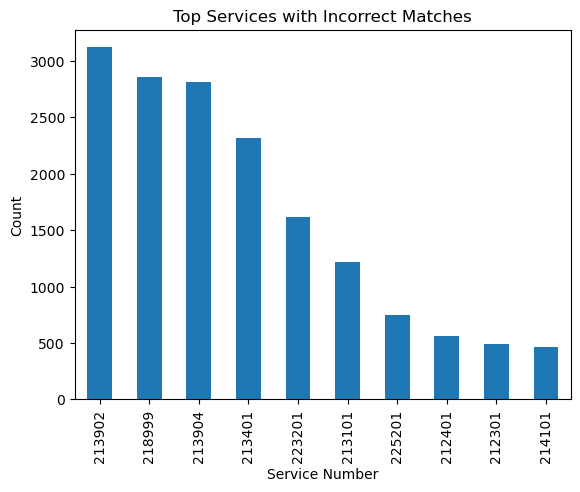

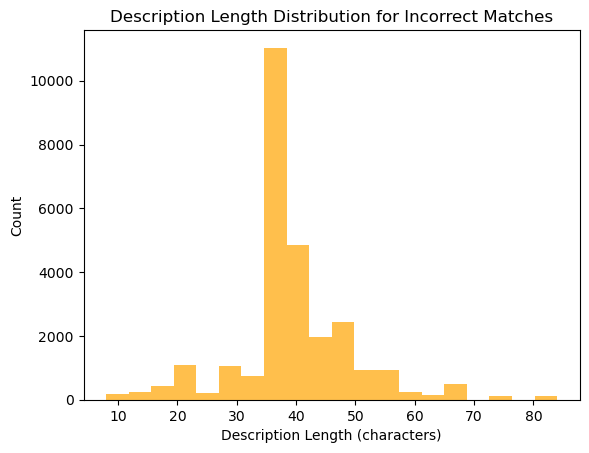

In [60]:
incorrect_df = df[~df["is_correct"]]

# Flatten the retrieved material numbers
incorrect_materials = incorrect_df.explode("retrieved_material_numbers")

def get_description_for_material(material_number, top_5_matches):
    for match in top_5_matches:
        if match["material_number"] == material_number:
            return match["description"]
    return "No description available"

incorrect_materials["retrieved_descriptions"] = incorrect_materials.apply(
    lambda row: get_description_for_material(row["retrieved_material_numbers"], row["retrieved_top_5"]),
    axis=1
)

# Add a column for description lengths
incorrect_materials["description_length"] = incorrect_materials["retrieved_descriptions"].apply(
    lambda desc: len(desc) if isinstance(desc, str) else 0
)

# Count the top incorrect material numbers
common_incorrect_matches = incorrect_materials["retrieved_material_numbers"].value_counts().head(10)

# Map to each material number
material_to_description = incorrect_materials.drop_duplicates("retrieved_material_numbers").set_index(
    "retrieved_material_numbers"
)[["retrieved_descriptions", "description_length"]].to_dict("index")

# print rows
print("Most Common Incorrect Matches with Description Lengths:")
for material_number, count in common_incorrect_matches.items():
    desc_info = material_to_description.get(material_number, {})
    description = desc_info.get("retrieved_descriptions", "No description available")
    desc_length = desc_info.get("description_length", 0)
    print(f"{material_number} - {description} (Count: {count}, Length: {desc_length} characters)")

# chart for top incorrect matches
common_incorrect_matches.plot(kind="bar", title="Top Services with Incorrect Matches")
plt.xlabel("Service Number")
plt.ylabel("Count")
plt.show()

# chart for description length distribution
incorrect_materials["description_length"].plot(kind="hist", bins=20, alpha=0.7, color="orange", title="Description Length Distribution for Incorrect Matches")
plt.xlabel("Description Length (characters)")
plt.ylabel("Count")
plt.show()

**Description length analysis for correct matches**

Most Common Correct Matches with Description Lengths:
218999 - Other Services-Other Manpower (Count: 1432, Length: 29 characters)
213904 - Service for Other Supplies(OOE only) (Count: 592, Length: 36 characters)
213201 - Service for Meals & Refreshments(OOE only) (Count: 447, Length: 42 characters)
218401 - Other Services-Postage and Courier Services (Count: 373, Length: 43 characters)
217401 - Tech Services-ICT Consultancy Services (Count: 366, Length: 38 characters)
213401 - Service for Uniform Supplies(OOE only) (Count: 361, Length: 38 characters)
218901 - Other Services-Special Services (Count: 350, Length: 31 characters)
223201 - Maintenance-Land Transport Facilities(OOE only) (Count: 261, Length: 47 characters)
213101 - Service for Office Supplies(OOE only) (Count: 187, Length: 37 characters)
212401 - Rental-Other Equipment (Count: 185, Length: 22 characters)


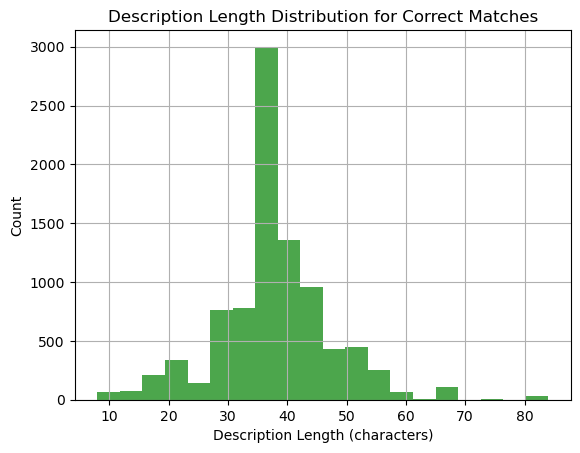

In [58]:
# Analyze correct predictions
correct_df = df[df["is_correct"]]
correct_materials = correct_df.explode("retrieved_material_numbers")

# Add descriptions for correct matches
correct_materials["retrieved_descriptions"] = correct_materials.apply(
    lambda row: get_description_for_material(row["retrieved_material_numbers"], row["retrieved_top_5"]),
    axis=1
)

# Add a column for description lengths for correct matches
correct_materials["description_length"] = correct_materials["retrieved_descriptions"].apply(
    lambda desc: len(desc) if isinstance(desc, str) else 0
)

# Count the most common correct material numbers
common_correct_matches = correct_materials["retrieved_material_numbers"].value_counts().head(10)

# Map material numbers to descriptions and their lengths
material_to_description_correct = correct_materials.drop_duplicates("retrieved_material_numbers").set_index(
    "retrieved_material_numbers"
)[["retrieved_descriptions", "description_length"]].to_dict("index")

# print rows
print("Most Common Correct Matches with Description Lengths:")
for material_number, count in common_correct_matches.items():
    desc_info = material_to_description_correct.get(material_number, {})
    description = desc_info.get("retrieved_descriptions", "No description available")
    desc_length = desc_info.get("description_length", 0)
    print(f"{material_number} - {description} (Count: {count}, Length: {desc_length} characters)")

# chart of description lengths distribution
correct_materials["description_length"].hist(bins=20, alpha=0.7, color="green", label="Correct Matches")
plt.title("Description Length Distribution for Correct Matches")
plt.xlabel("Description Length (characters)")
plt.ylabel("Count")
#plt.legend()
plt.show()

**Query Length Analysis**

In [ ]:
# # Calculate query lengths
# df["query_length"] = df["query"].apply(len)

# # Group accuracy by query length ranges
# bins = [0, 50, 100, 150, 200]
# df["query_length_bin"] = pd.cut(df["query_length"], bins)
# accuracy_by_length = df.groupby("query_length_bin")["is_correct"].mean()

# print("Accuracy by Query Length:")
# print(accuracy_by_length)

# # Plot accuracy by query length
# accuracy_by_length.plot(kind="bar", title="Accuracy by Query Length")
# plt.xlabel("Query Length Range")
# plt.ylabel("Accuracy")
# plt.show()